# Recommender Systems
recommmendation system: presents items to users in a relevant way

user: party that is receiving Recommendations
item: the passive party that is being recommended to users  

Content based vs collaborative filtering
In practice most will be hybrid.

## Recommendations at Expedia Group
https://confluence.expedia.biz/pages/viewpage.action?pageId=890552932

https://www.dropbox.com/s/cf77o15jlahabay/wid-eps-recommendations.pdf

## Collaborative Filtering

* Memory Based - KNearest Neighbours
* Model Based - SVD
* and others

# K Nearest Neighbours

In [1]:
import pandas as pd

def display_matrix(data):
  df = pd.DataFrame(data) 
  df.rename(columns=lambda x: "item" + str(x), inplace=True)
  df.rename(index = lambda x: "user" + str(x), inplace=True)
  return df


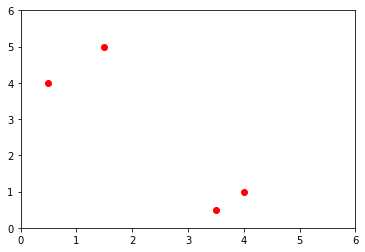

In [2]:
from scipy import spatial
import matplotlib.pyplot as plt
import itertools
from sklearn.neighbors import NearestNeighbors
import math


def points(xs):
    return [[x[0] for x in xs],[x[1] for x in xs]]

def plot(xs):
    ps = points(xs)
    plt.plot(ps[0],ps[1], 'ro')
    mx = max([max(ps[0]), max(ps[1])])
    mn = min([min(ps[0]), min(ps[1]), 0])
    gap = math.ceil((mx - mn) / 10)
    plt.axis([mn, mx + gap, mn, mx + gap])


# https://realpython.com/build-recommendation-engine-collaborative-filtering/
# conceptually we can say that these are users with explicit ratings for movies x and y
# or we could say that they're
pts = [
    [4, 1],
    [3.5, 0.5],
    [0.5, 4],
    [1.5, 5]
]

plot(pts)

In [3]:
display_matrix(pts)

,item0,item1
user0,4.0,1.0
user1,3.5,0.5
user2,0.5,4.0
user3,1.5,5.0


In [4]:
# User-based collaborative filtering:
# Find the users who have similar taste of products as the current user, similarity is based on purchasing behavior of the user, so based on the neighbor purchasing behavior we can recommend items to the current user.
import numpy as np

# TBD
# Let's build up intuitions
# Lets add a new user who gave movie x a certain rating but hasn't given one for movie y; what rating will she give to movie y?

pts = [
    [4, 1],
    [3.5, 0.5],
    [0.5, 4],
    [1.5, 5]
]

# Let's say that her rating will be the average of the ratings given by the nearest 2 users for movie y

def predicted_rating(x, points, num_neighbors=2):
    points = np.array(points)
    for i in range(len(points)):
        points[i][0] = abs(points[i][0] - x)

    sorted_pts = points[np.argsort(points[:,0])]
    y_neighbors = sorted_pts[:num_neighbors]

    return y_neighbors[0][1] if len(y_neighbors) == 1 else np.sum(y_neighbors[:,1])/num_neighbors

print(predicted_rating(5, pts, 1))
print(predicted_rating(3.5, pts, 2))

# Problems with this?
# If inbetween 3.5 and 1.5 will take y to be average of those scores which will be wildly off
# If not between existing score i.e. 5 it will not scale with higher score

1.0
0.75


In [5]:
# Now let's see if we can try using sklearn's nearest neighbour's library

neigh = NearestNeighbors(n_neighbors=1, metric='euclidean')
neigh.fit(pts)

print(neigh.kneighbors([[4,1]]))
print(neigh.kneighbors([[4,1.1]]))
print(neigh.kneighbors([[5,2]]))
print(neigh.kneighbors([[1,5]]))

# What's wrong with the result here?
# Distances are very small, not a great sensitivity to close neighbors

(array([[0.]]), array([[0]]))
(array([[0.1]]), array([[0]]))
(array([[1.41421356]]), array([[0]]))
(array([[0.5]]), array([[3]]))


In [6]:
def normalise(x):
    avg = (x[0] + x[1]) / 2
    return [x[0] - avg, x[1] - avg]

display_matrix([normalise(pt) for pt in pts])

,item0,item1
user0,1.50,-1.50
user1,1.50,-1.50
user2,-1.75,1.75
user3,-1.75,1.75


In [7]:
def explain(coord):
    neigh = NearestNeighbors(n_neighbors=2)
    neigh.fit([normalise(pt) for pt in pts])
    distance, index = neigh.kneighbors([coord])
    print(f'Nearest 2 neighbors to a User of rating {coord}')
    print('====')
    print(f'Nearest Neighbors are Users: {index[0][0]} and {index[0][1]}')
    print(f'Neighbor 1 (User {index[0][0]}) euclidian distance of: {distance[0][0]}')
    print(f'Neighbor 2 (User {index[0][1]}) euclidian distance of: {distance[0][1]}\n')

explain([0.1, 0])
explain([3.4, 0.2])
explain([1.5, 4])

Nearest 2 neighbors to a User of rating [0.1, 0]
====
Nearest Neighbors are Users: 0 and 1
Neighbor 1 (User 0) euclidian distance of: 2.0518284528683193
Neighbor 2 (User 1) euclidian distance of: 2.0518284528683193

Nearest 2 neighbors to a User of rating [3.4, 0.2]
====
Nearest Neighbors are Users: 0 and 1
Neighbor 1 (User 0) euclidian distance of: 2.5495097567963922
Neighbor 2 (User 1) euclidian distance of: 2.5495097567963922

Nearest 2 neighbors to a User of rating [1.5, 4]
====
Nearest Neighbors are Users: 2 and 3
Neighbor 1 (User 2) euclidian distance of: 3.952847075210474
Neighbor 2 (User 3) euclidian distance of: 3.952847075210474



In [8]:
# Let's add some items and introduce some sparsity
pts = [
    [4, 1, None, None],
    [3.5, 0.5, None, 2],
    [None, None, 3, 4],
    [0.5, 4, None, None],
    [1.5, 5, None, None]
]
display_matrix(pts)

,item0,item1,item2,item3
user0,4.0,1.0,NaN,NaN
user1,3.5,0.5,NaN,2.0
user2,NaN,NaN,3.0,4.0
user3,0.5,4.0,NaN,NaN
user4,1.5,5.0,NaN,NaN


In [9]:
def normalise(xs):
    nxs = list(filter(lambda x: x is not None, xs))
    avg = sum(nxs) / len(nxs)
    return [0.0 if x is None else x - avg for x in xs]

In [10]:
df = display_matrix([normalise(pt) for pt in pts])
df

,item0,item1,item2,item3
user0,1.50,-1.50,0.0,0.0
user1,1.50,-1.50,0.0,0.0
user2,0.00,0.00,-0.5,0.5
user3,-1.75,1.75,0.0,0.0
user4,-1.75,1.75,0.0,0.0


In [11]:
# TDB: Write a function to predict ratings for a new entry 
def predicted_rating(x, pts):
  clean = list(filter(lambda x: x is not None, pts))
  norm_pts = display_matrix([normalise(pt) for pt in pts])

  nn = NearestNeighbors(n_neighbors=2)
  nn.fit(norm_pts)
  distance, index = nn.kneighbors([x])

  userA = list(filter(lambda x: x is not None, pts[index[0][0]]))
  userB = list(filter(lambda x: x is not None, pts[index[0][1]]))

  print(f'Similar to Users: {index[0][0]} and {index[0][1]}')
  print('======')
  print(f'User {index[0][0]} likes: item{userA.index(max(userA))} most')
  print(f'User {index[0][1]} likes: item{userB.index(max(userB))} most\n')

predicted_rating([2, 0, 0, 0], pts)

Similar to Users: 0 and 1
User 0 likes: item0 most
User 1 likes: item0 most



In [13]:
pts = [
    [4, 1, None, None],
    [3.5, 0.5, None, 2],
    [None, None, 3, 4],
    [0.5, 4, None, None],
    [2.5, 3, None, None],
    [3, 2, None, None],
    [3.5, 5, None, 1],
    [None, None, 5, 5],
    [None, None, 4, 3],
    [None, None, 4, 3],
    [3.5, 2, None, None],
    [4.5, 1, None, None]
]

predicted_rating([4.5, 1, 0, 0], pts)
predicted_rating([0, 5, 0, 0], pts)
predicted_rating([0, 0, 0, 1], pts)

Similar to Users: 11 and 0
User 11 likes: item0 most
User 0 likes: item0 most

Similar to Users: 3 and 6
User 3 likes: item1 most
User 6 likes: item1 most

Similar to Users: 2 and 7
User 2 likes: item1 most
User 7 likes: item0 most

